In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

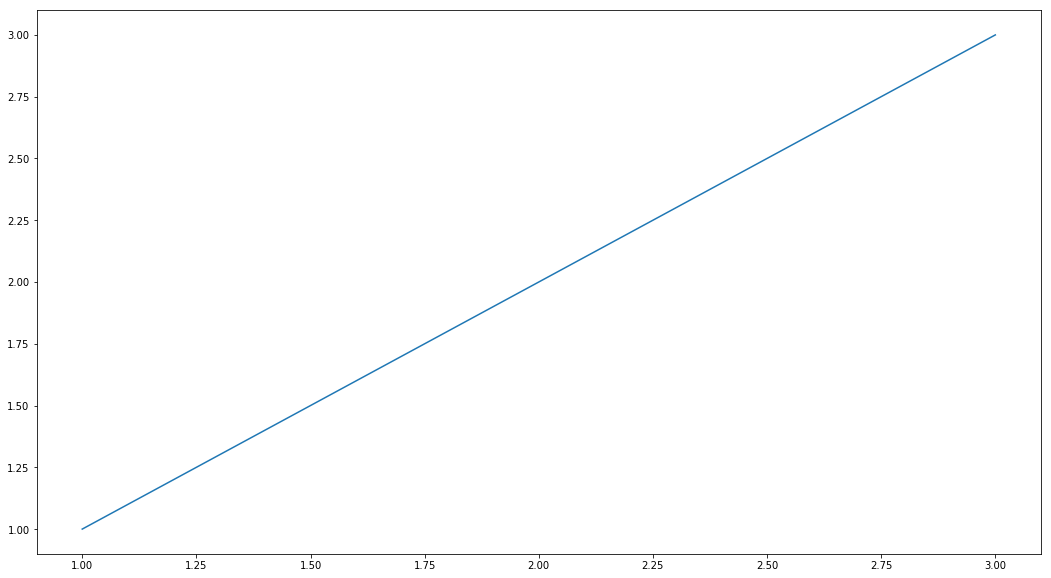

In [3]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,10))
x = [1,2,3]
plt.plot(x, x)
plt.show()

In [4]:
#encoding: utf-8
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam
from keras import callbacks

Using TensorFlow backend.


In [5]:
import time

In [6]:
class QNetwork:
    def __init__(self, is_load_weights=False, learning_rate=0.01, state_size=4,
                 action_size=2, hidden_size=24, model_name="cartpole-dqn"):
        self.backup_path = "./" + model_name + ".h5"
        
        # state inputs to the Q-network
        self.model = Sequential()

        self.model.add(Dense(hidden_size, activation='relu',
                             input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))

        self.optimizer = Adam(lr=learning_rate)
        self.model.compile(loss='mse', optimizer=self.optimizer)
        if (is_load_weights):
            print("load model weights from " + self.backup_path)
            if os.path.isfile(self.backup_path):
                self.model.load_weights(self.backup_path)
                print("Done")
                # self.exploration_rate = self.exploration_min
            else:
                print("Fail")
        # print(self.model.summary())
        
    def save_model(self):
        print("save model weights to " + self.backup_path)
        self.model.save(self.backup_path)


In [7]:
class Memory():
    def __init__(self, max_size=2000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]      

In [8]:
class Agent():
    def __init__(self, state_size, action_size, model):
        self.model              = model
        self.state_size         = state_size
        self.action_size        = action_size
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.99

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def modify_exploration_rate(self):
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
        # print("exploration_rate=", self.exploration_rate)


In [9]:
class CartPole:
    def __init__(self, episodes=1000):
        self.model_name         = "cartpole_yo_v0"
        self.sample_batch_size  = 32
        self.episodes           = episodes
        self.gamma              = 0.99
        self.env                = gym.make('CartPole-v0')
        self.state_size         = self.env.observation_space.shape[0]
        self.action_size        = self.env.action_space.n
        self.memory             = Memory(max_size=1000)
        self.network            = QNetwork(is_load_weights=False, state_size=self.state_size, action_size=self.action_size, 
                                           hidden_size=16, learning_rate=0.001, model_name=self.model_name)
        self.agent              = Agent(self.state_size, self.action_size, self.network.model)
        tensorboard_path = "./TensorBoard/" + self.model_name
        self.tboard_callback = callbacks.TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=True, write_images=True)
        self.env.seed(13)
        self.save_model = True

    def run(self, isRender=False):
        scores = []
        start = time.time()
        print('Experiment start at ', time.ctime())
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

                done = False
                index = 0
                while not done:
                    if isRender:
                        self.env.render()

                    action = self.agent.act(state)
                    next_state, reward, done, _ = self.env.step(action)
                    if done:
                        reward = -1
                        self.memory.add((state, action, reward, None, done))
                    else:
                        next_state = np.reshape(next_state, [1, self.state_size])
                        self.memory.add((state, action, reward, next_state, done))
                        state = next_state
                    index += 1
                print("Episode {}# Score: {}".format(index_episode, index))
                scores.append(index)
                if len(self.memory.buffer) >= self.sample_batch_size:
                    self.train_network()
                    self.agent.modify_exploration_rate()
        finally:
            end = time.time()
            print('Experiment end at ', time.ctime())
            print('Time consumed ', end - start)
            if self.save_model:
                self.network.save_model()
                
        return scores
            
    def train_network(self):
        sample_batch = self.memory.sample(self.sample_batch_size)
        model = self.network.model
        for state, action, reward, next_state, done in sample_batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(model.predict(next_state)[0])
            target_f = model.predict(state)
            target_f[0][action] = target
            # model.fit(state, target_f, epochs=1, verbose=0, callbacks=[self.tboard_callback])
            model.fit(state, target_f, epochs=1, verbose=0)


In [10]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=int)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Experiment start at  Tue Jan  8 14:53:50 2019
Episode 0# Score: 15
Episode 1# Score: 17
Episode 2# Score: 15
Episode 3# Score: 14
Episode 4# Score: 34
Episode 5# Score: 25
Episode 6# Score: 18
Episode 7# Score: 23
Episode 8# Score: 12
Episode 9# Score: 62
Episode 10# Score: 73
Episode 11# Score: 11
Episode 12# Score: 11
Episode 13# Score: 12
Episode 14# Score: 17
Episode 15# Score: 12
Episode 16# Score: 12
Episode 17# Score: 11
Episode 18# Score: 12
Episode 19# Score: 13
Episode 20# Score: 14
Episode 21# Score: 14
Episode 22# Score: 25
Episode 23# Score: 43
Episode 24# Score: 43
Episode 25# Score: 23
Episode 26# Score: 12
Episode 27# Score: 12
Episode 28# Score: 15
Episode 29# Score: 38
Episode 30# Score: 19
Episode 31# Score: 28
Episode 32# Score: 26
Episode 33# Score: 17
Episode 34# Score: 15
Episode 35# Score: 10
Episode 36# Score: 22
Episode 37# Score: 8
Episode 38# Score: 14
Episode 39# Score: 14
Episode 40# Score: 19
Episode 41# Score: 17
Episode 42# Score: 43
Episode 43# Score: 

Episode 360# Score: 38
Episode 361# Score: 21
Episode 362# Score: 27
Episode 363# Score: 30
Episode 364# Score: 46
Episode 365# Score: 47
Episode 366# Score: 24
Episode 367# Score: 46
Episode 368# Score: 36
Episode 369# Score: 63
Episode 370# Score: 27
Episode 371# Score: 23
Episode 372# Score: 28
Episode 373# Score: 37
Episode 374# Score: 16
Episode 375# Score: 15
Episode 376# Score: 17
Episode 377# Score: 66
Episode 378# Score: 99
Episode 379# Score: 58
Episode 380# Score: 12
Episode 381# Score: 14
Episode 382# Score: 48
Episode 383# Score: 65
Episode 384# Score: 66
Episode 385# Score: 33
Episode 386# Score: 23
Episode 387# Score: 45
Episode 388# Score: 67
Episode 389# Score: 88
Episode 390# Score: 24
Episode 391# Score: 24
Episode 392# Score: 24
Episode 393# Score: 21
Episode 394# Score: 16
Episode 395# Score: 21
Episode 396# Score: 48
Episode 397# Score: 14
Episode 398# Score: 15
Episode 399# Score: 20
Episode 400# Score: 25
Episode 401# Score: 119
Episode 402# Score: 23
Episode 40

Episode 713# Score: 99
Episode 714# Score: 104
Episode 715# Score: 84
Episode 716# Score: 128
Episode 717# Score: 130
Episode 718# Score: 138
Episode 719# Score: 141
Episode 720# Score: 146
Episode 721# Score: 142
Episode 722# Score: 91
Episode 723# Score: 87
Episode 724# Score: 25
Episode 725# Score: 113
Episode 726# Score: 151
Episode 727# Score: 111
Episode 728# Score: 117
Episode 729# Score: 32
Episode 730# Score: 17
Episode 731# Score: 200
Episode 732# Score: 15
Episode 733# Score: 11
Episode 734# Score: 9
Episode 735# Score: 9
Episode 736# Score: 9
Episode 737# Score: 8
Episode 738# Score: 9
Episode 739# Score: 17
Episode 740# Score: 22
Episode 741# Score: 200
Episode 742# Score: 187
Episode 743# Score: 31
Episode 744# Score: 91
Episode 745# Score: 18
Episode 746# Score: 15
Episode 747# Score: 17
Episode 748# Score: 19
Episode 749# Score: 18
Episode 750# Score: 25
Episode 751# Score: 20
Episode 752# Score: 29
Episode 753# Score: 31
Episode 754# Score: 36
Episode 755# Score: 200
E

Episode 1057# Score: 124
Episode 1058# Score: 145
Episode 1059# Score: 155
Episode 1060# Score: 146
Episode 1061# Score: 147
Episode 1062# Score: 130
Episode 1063# Score: 129
Episode 1064# Score: 141
Episode 1065# Score: 165
Episode 1066# Score: 151
Episode 1067# Score: 143
Episode 1068# Score: 170
Episode 1069# Score: 147
Episode 1070# Score: 146
Episode 1071# Score: 159
Episode 1072# Score: 155
Episode 1073# Score: 148
Episode 1074# Score: 144
Episode 1075# Score: 148
Episode 1076# Score: 137
Episode 1077# Score: 158
Episode 1078# Score: 144
Episode 1079# Score: 143
Episode 1080# Score: 134
Episode 1081# Score: 139
Episode 1082# Score: 132
Episode 1083# Score: 154
Episode 1084# Score: 152
Episode 1085# Score: 166
Episode 1086# Score: 175
Episode 1087# Score: 157
Episode 1088# Score: 181
Episode 1089# Score: 140
Episode 1090# Score: 155
Episode 1091# Score: 133
Episode 1092# Score: 158
Episode 1093# Score: 144
Episode 1094# Score: 178
Episode 1095# Score: 170
Episode 1096# Score: 152


Episode 1387# Score: 102
Episode 1388# Score: 18
Episode 1389# Score: 17
Episode 1390# Score: 15
Episode 1391# Score: 22
Episode 1392# Score: 21
Episode 1393# Score: 16
Episode 1394# Score: 17
Episode 1395# Score: 21
Episode 1396# Score: 22
Episode 1397# Score: 20
Episode 1398# Score: 108
Episode 1399# Score: 103
Episode 1400# Score: 109
Episode 1401# Score: 100
Episode 1402# Score: 17
Episode 1403# Score: 17
Episode 1404# Score: 24
Episode 1405# Score: 111
Episode 1406# Score: 23
Episode 1407# Score: 103
Episode 1408# Score: 104
Episode 1409# Score: 109
Episode 1410# Score: 21
Episode 1411# Score: 97
Episode 1412# Score: 106
Episode 1413# Score: 108
Episode 1414# Score: 107
Episode 1415# Score: 113
Episode 1416# Score: 104
Episode 1417# Score: 103
Episode 1418# Score: 96
Episode 1419# Score: 24
Episode 1420# Score: 18
Episode 1421# Score: 25
Episode 1422# Score: 24
Episode 1423# Score: 22
Episode 1424# Score: 26
Episode 1425# Score: 98
Episode 1426# Score: 102
Episode 1427# Score: 20


Episode 1717# Score: 108
Episode 1718# Score: 98
Episode 1719# Score: 96
Episode 1720# Score: 99
Episode 1721# Score: 72
Episode 1722# Score: 76
Episode 1723# Score: 87
Episode 1724# Score: 64
Episode 1725# Score: 87
Episode 1726# Score: 63
Episode 1727# Score: 77
Episode 1728# Score: 82
Episode 1729# Score: 78
Episode 1730# Score: 73
Episode 1731# Score: 74
Episode 1732# Score: 84
Episode 1733# Score: 68
Episode 1734# Score: 64
Episode 1735# Score: 71
Episode 1736# Score: 84
Episode 1737# Score: 55
Episode 1738# Score: 80
Episode 1739# Score: 71
Episode 1740# Score: 56
Episode 1741# Score: 79
Episode 1742# Score: 59
Episode 1743# Score: 61
Episode 1744# Score: 70
Episode 1745# Score: 56
Episode 1746# Score: 58
Episode 1747# Score: 57
Episode 1748# Score: 64
Episode 1749# Score: 50
Episode 1750# Score: 50
Episode 1751# Score: 49
Episode 1752# Score: 63
Episode 1753# Score: 42
Episode 1754# Score: 51
Episode 1755# Score: 40
Episode 1756# Score: 35
Episode 1757# Score: 42
Episode 1758# S

Episode 2051# Score: 112
Episode 2052# Score: 200
Episode 2053# Score: 130
Episode 2054# Score: 135
Episode 2055# Score: 128
Episode 2056# Score: 127
Episode 2057# Score: 112
Episode 2058# Score: 139
Episode 2059# Score: 123
Episode 2060# Score: 135
Episode 2061# Score: 138
Episode 2062# Score: 150
Episode 2063# Score: 139
Episode 2064# Score: 155
Episode 2065# Score: 163
Episode 2066# Score: 200
Episode 2067# Score: 200
Episode 2068# Score: 200
Episode 2069# Score: 200
Episode 2070# Score: 200
Episode 2071# Score: 200
Episode 2072# Score: 200
Episode 2073# Score: 176
Episode 2074# Score: 164
Episode 2075# Score: 113
Episode 2076# Score: 128
Episode 2077# Score: 120
Episode 2078# Score: 119
Episode 2079# Score: 108
Episode 2080# Score: 116
Episode 2081# Score: 129
Episode 2082# Score: 136
Episode 2083# Score: 160
Episode 2084# Score: 200
Episode 2085# Score: 200
Episode 2086# Score: 200
Episode 2087# Score: 200
Episode 2088# Score: 32
Episode 2089# Score: 186
Episode 2090# Score: 200
E

Episode 2381# Score: 200
Episode 2382# Score: 200
Episode 2383# Score: 200
Episode 2384# Score: 200
Episode 2385# Score: 176
Episode 2386# Score: 194
Episode 2387# Score: 182
Episode 2388# Score: 200
Episode 2389# Score: 200
Episode 2390# Score: 200
Episode 2391# Score: 200
Episode 2392# Score: 200
Episode 2393# Score: 112
Episode 2394# Score: 152
Episode 2395# Score: 163
Episode 2396# Score: 200
Episode 2397# Score: 200
Episode 2398# Score: 200
Episode 2399# Score: 20
Episode 2400# Score: 21
Episode 2401# Score: 116
Episode 2402# Score: 147
Episode 2403# Score: 179
Episode 2404# Score: 197
Episode 2405# Score: 20
Episode 2406# Score: 14
Episode 2407# Score: 18
Episode 2408# Score: 92
Episode 2409# Score: 101
Episode 2410# Score: 50
Episode 2411# Score: 21
Episode 2412# Score: 99
Episode 2413# Score: 18
Episode 2414# Score: 92
Episode 2415# Score: 96
Episode 2416# Score: 34
Episode 2417# Score: 13
Episode 2418# Score: 19
Episode 2419# Score: 12
Episode 2420# Score: 22
Episode 2421# Sco

Episode 2711# Score: 200
Episode 2712# Score: 200
Episode 2713# Score: 200
Episode 2714# Score: 200
Episode 2715# Score: 200
Episode 2716# Score: 200
Episode 2717# Score: 125
Episode 2718# Score: 15
Episode 2719# Score: 10
Episode 2720# Score: 9
Episode 2721# Score: 9
Episode 2722# Score: 8
Episode 2723# Score: 8
Episode 2724# Score: 9
Episode 2725# Score: 11
Episode 2726# Score: 9
Episode 2727# Score: 9
Episode 2728# Score: 9
Episode 2729# Score: 8
Episode 2730# Score: 10
Episode 2731# Score: 10
Episode 2732# Score: 10
Episode 2733# Score: 10
Episode 2734# Score: 10
Episode 2735# Score: 12
Episode 2736# Score: 12
Episode 2737# Score: 11
Episode 2738# Score: 25
Episode 2739# Score: 158
Episode 2740# Score: 176
Episode 2741# Score: 23
Episode 2742# Score: 14
Episode 2743# Score: 9
Episode 2744# Score: 11
Episode 2745# Score: 12
Episode 2746# Score: 9
Episode 2747# Score: 10
Episode 2748# Score: 11
Episode 2749# Score: 11
Episode 2750# Score: 10
Episode 2751# Score: 9
Episode 2752# Score

Episode 3053# Score: 35
Episode 3054# Score: 24
Episode 3055# Score: 23
Episode 3056# Score: 33
Episode 3057# Score: 37
Episode 3058# Score: 35
Episode 3059# Score: 28
Episode 3060# Score: 23
Episode 3061# Score: 22
Episode 3062# Score: 26
Episode 3063# Score: 43
Episode 3064# Score: 22
Episode 3065# Score: 38
Episode 3066# Score: 26
Episode 3067# Score: 30
Episode 3068# Score: 24
Episode 3069# Score: 39
Episode 3070# Score: 32
Episode 3071# Score: 26
Episode 3072# Score: 24
Episode 3073# Score: 17
Episode 3074# Score: 25
Episode 3075# Score: 34
Episode 3076# Score: 22
Episode 3077# Score: 36
Episode 3078# Score: 26
Episode 3079# Score: 27
Episode 3080# Score: 34
Episode 3081# Score: 29
Episode 3082# Score: 37
Episode 3083# Score: 42
Episode 3084# Score: 30
Episode 3085# Score: 31
Episode 3086# Score: 30
Episode 3087# Score: 33
Episode 3088# Score: 32
Episode 3089# Score: 33
Episode 3090# Score: 35
Episode 3091# Score: 35
Episode 3092# Score: 31
Episode 3093# Score: 33
Episode 3094# Sc

Episode 3387# Score: 200
Episode 3388# Score: 200
Episode 3389# Score: 190
Episode 3390# Score: 200
Episode 3391# Score: 200
Episode 3392# Score: 200
Episode 3393# Score: 200
Episode 3394# Score: 200
Episode 3395# Score: 200
Episode 3396# Score: 200
Episode 3397# Score: 200
Episode 3398# Score: 200
Episode 3399# Score: 200
Episode 3400# Score: 156
Episode 3401# Score: 195
Episode 3402# Score: 200
Episode 3403# Score: 200
Episode 3404# Score: 200
Episode 3405# Score: 200
Episode 3406# Score: 200
Episode 3407# Score: 174
Episode 3408# Score: 91
Episode 3409# Score: 95
Episode 3410# Score: 77
Episode 3411# Score: 73
Episode 3412# Score: 200
Episode 3413# Score: 200
Episode 3414# Score: 78
Episode 3415# Score: 200
Episode 3416# Score: 75
Episode 3417# Score: 21
Episode 3418# Score: 21
Episode 3419# Score: 19
Episode 3420# Score: 16
Episode 3421# Score: 15
Episode 3422# Score: 16
Episode 3423# Score: 20
Episode 3424# Score: 20
Episode 3425# Score: 15
Episode 3426# Score: 20
Episode 3427# Sc

Episode 3718# Score: 200
Episode 3719# Score: 200
Episode 3720# Score: 200
Episode 3721# Score: 200
Episode 3722# Score: 200
Episode 3723# Score: 200
Episode 3724# Score: 200
Episode 3725# Score: 175
Episode 3726# Score: 200
Episode 3727# Score: 200
Episode 3728# Score: 200
Episode 3729# Score: 200
Episode 3730# Score: 200
Episode 3731# Score: 200
Episode 3732# Score: 200
Episode 3733# Score: 200
Episode 3734# Score: 200
Episode 3735# Score: 200
Episode 3736# Score: 200
Episode 3737# Score: 200
Episode 3738# Score: 200
Episode 3739# Score: 200
Episode 3740# Score: 200
Episode 3741# Score: 200
Episode 3742# Score: 200
Episode 3743# Score: 200
Episode 3744# Score: 200
Episode 3745# Score: 200
Episode 3746# Score: 134
Episode 3747# Score: 200
Episode 3748# Score: 200
Episode 3749# Score: 200
Episode 3750# Score: 200
Episode 3751# Score: 200
Episode 3752# Score: 200
Episode 3753# Score: 200
Episode 3754# Score: 200
Episode 3755# Score: 200
Episode 3756# Score: 138
Episode 3757# Score: 200


Episode 4047# Score: 200
Episode 4048# Score: 200
Episode 4049# Score: 200
Episode 4050# Score: 179
Episode 4051# Score: 189
Episode 4052# Score: 186
Episode 4053# Score: 168
Episode 4054# Score: 194
Episode 4055# Score: 185
Episode 4056# Score: 159
Episode 4057# Score: 133
Episode 4058# Score: 138
Episode 4059# Score: 139
Episode 4060# Score: 142
Episode 4061# Score: 108
Episode 4062# Score: 87
Episode 4063# Score: 90
Episode 4064# Score: 89
Episode 4065# Score: 91
Episode 4066# Score: 85
Episode 4067# Score: 94
Episode 4068# Score: 97
Episode 4069# Score: 102
Episode 4070# Score: 87
Episode 4071# Score: 88
Episode 4072# Score: 71
Episode 4073# Score: 60
Episode 4074# Score: 56
Episode 4075# Score: 60
Episode 4076# Score: 55
Episode 4077# Score: 53
Episode 4078# Score: 61
Episode 4079# Score: 53
Episode 4080# Score: 66
Episode 4081# Score: 86
Episode 4082# Score: 69
Episode 4083# Score: 84
Episode 4084# Score: 84
Episode 4085# Score: 65
Episode 4086# Score: 67
Episode 4087# Score: 156

Episode 4379# Score: 10
Episode 4380# Score: 11
Episode 4381# Score: 200
Episode 4382# Score: 200
Episode 4383# Score: 200
Episode 4384# Score: 200
Episode 4385# Score: 200
Episode 4386# Score: 200
Episode 4387# Score: 200
Episode 4388# Score: 200
Episode 4389# Score: 200
Episode 4390# Score: 200
Episode 4391# Score: 200
Episode 4392# Score: 200
Episode 4393# Score: 200
Episode 4394# Score: 200
Episode 4395# Score: 200
Episode 4396# Score: 200
Episode 4397# Score: 200
Episode 4398# Score: 200
Episode 4399# Score: 200
Episode 4400# Score: 200
Episode 4401# Score: 200
Episode 4402# Score: 200
Episode 4403# Score: 200
Episode 4404# Score: 200
Episode 4405# Score: 200
Episode 4406# Score: 200
Episode 4407# Score: 200
Episode 4408# Score: 200
Episode 4409# Score: 200
Episode 4410# Score: 200
Episode 4411# Score: 200
Episode 4412# Score: 200
Episode 4413# Score: 200
Episode 4414# Score: 200
Episode 4415# Score: 200
Episode 4416# Score: 200
Episode 4417# Score: 200
Episode 4418# Score: 200
Ep

Episode 4710# Score: 200
Episode 4711# Score: 200
Episode 4712# Score: 200
Episode 4713# Score: 200
Episode 4714# Score: 68
Episode 4715# Score: 19
Episode 4716# Score: 70
Episode 4717# Score: 30
Episode 4718# Score: 77
Episode 4719# Score: 78
Episode 4720# Score: 15
Episode 4721# Score: 21
Episode 4722# Score: 200
Episode 4723# Score: 200
Episode 4724# Score: 200
Episode 4725# Score: 200
Episode 4726# Score: 20
Episode 4727# Score: 13
Episode 4728# Score: 11
Episode 4729# Score: 10
Episode 4730# Score: 15
Episode 4731# Score: 19
Episode 4732# Score: 20
Episode 4733# Score: 15
Episode 4734# Score: 15
Episode 4735# Score: 22
Episode 4736# Score: 24
Episode 4737# Score: 32
Episode 4738# Score: 200
Episode 4739# Score: 200
Episode 4740# Score: 200
Episode 4741# Score: 200
Episode 4742# Score: 200
Episode 4743# Score: 200
Episode 4744# Score: 200
Episode 4745# Score: 200
Episode 4746# Score: 200
Episode 4747# Score: 200
Episode 4748# Score: 200
Episode 4749# Score: 200
Episode 4750# Score:

Episode 5041# Score: 200
Episode 5042# Score: 200
Episode 5043# Score: 200
Episode 5044# Score: 200
Episode 5045# Score: 200
Episode 5046# Score: 200
Episode 5047# Score: 200
Episode 5048# Score: 200
Episode 5049# Score: 200
Episode 5050# Score: 200
Episode 5051# Score: 200
Episode 5052# Score: 200
Episode 5053# Score: 200
Episode 5054# Score: 200
Episode 5055# Score: 200
Episode 5056# Score: 200
Episode 5057# Score: 200
Episode 5058# Score: 200
Episode 5059# Score: 200
Episode 5060# Score: 200
Episode 5061# Score: 200
Episode 5062# Score: 200
Episode 5063# Score: 200
Episode 5064# Score: 200
Episode 5065# Score: 200
Episode 5066# Score: 200
Episode 5067# Score: 200
Episode 5068# Score: 200
Episode 5069# Score: 200
Episode 5070# Score: 200
Episode 5071# Score: 200
Episode 5072# Score: 200
Episode 5073# Score: 200
Episode 5074# Score: 200
Episode 5075# Score: 200
Episode 5076# Score: 200
Episode 5077# Score: 200
Episode 5078# Score: 200
Episode 5079# Score: 200
Episode 5080# Score: 200


Episode 5372# Score: 123
Episode 5373# Score: 120
Episode 5374# Score: 200
Episode 5375# Score: 27
Episode 5376# Score: 19
Episode 5377# Score: 16
Episode 5378# Score: 14
Episode 5379# Score: 10
Episode 5380# Score: 13
Episode 5381# Score: 18
Episode 5382# Score: 19
Episode 5383# Score: 162
Episode 5384# Score: 200
Episode 5385# Score: 200
Episode 5386# Score: 200
Episode 5387# Score: 200
Episode 5388# Score: 200
Episode 5389# Score: 200
Episode 5390# Score: 200
Episode 5391# Score: 200
Episode 5392# Score: 200
Episode 5393# Score: 200
Episode 5394# Score: 200
Episode 5395# Score: 200
Episode 5396# Score: 200
Episode 5397# Score: 200
Episode 5398# Score: 200
Episode 5399# Score: 200
Episode 5400# Score: 200
Episode 5401# Score: 200
Episode 5402# Score: 200
Episode 5403# Score: 200
Episode 5404# Score: 200
Episode 5405# Score: 200
Episode 5406# Score: 200
Episode 5407# Score: 200
Episode 5408# Score: 200
Episode 5409# Score: 200
Episode 5410# Score: 200
Episode 5411# Score: 200
Episode 

Episode 5702# Score: 200
Episode 5703# Score: 200
Episode 5704# Score: 200
Episode 5705# Score: 200
Episode 5706# Score: 200
Episode 5707# Score: 200
Episode 5708# Score: 200
Episode 5709# Score: 200
Episode 5710# Score: 200
Episode 5711# Score: 200
Episode 5712# Score: 200
Episode 5713# Score: 200
Episode 5714# Score: 200
Episode 5715# Score: 200
Episode 5716# Score: 200
Episode 5717# Score: 200
Episode 5718# Score: 200
Episode 5719# Score: 200
Episode 5720# Score: 200
Episode 5721# Score: 200
Episode 5722# Score: 200
Episode 5723# Score: 200
Episode 5724# Score: 200
Episode 5725# Score: 200
Episode 5726# Score: 200
Episode 5727# Score: 200
Episode 5728# Score: 200
Episode 5729# Score: 200
Episode 5730# Score: 200
Episode 5731# Score: 200
Episode 5732# Score: 200
Episode 5733# Score: 200
Episode 5734# Score: 200
Episode 5735# Score: 200
Episode 5736# Score: 200
Episode 5737# Score: 200
Episode 5738# Score: 200
Episode 5739# Score: 200
Episode 5740# Score: 200
Episode 5741# Score: 200


Episode 6031# Score: 9
Episode 6032# Score: 13
Episode 6033# Score: 23
Episode 6034# Score: 200
Episode 6035# Score: 200
Episode 6036# Score: 200
Episode 6037# Score: 200
Episode 6038# Score: 200
Episode 6039# Score: 200
Episode 6040# Score: 200
Episode 6041# Score: 200
Episode 6042# Score: 200
Episode 6043# Score: 200
Episode 6044# Score: 200
Episode 6045# Score: 200
Episode 6046# Score: 200
Episode 6047# Score: 200
Episode 6048# Score: 200
Episode 6049# Score: 200
Episode 6050# Score: 200
Episode 6051# Score: 200
Episode 6052# Score: 200
Episode 6053# Score: 200
Episode 6054# Score: 200
Episode 6055# Score: 200
Episode 6056# Score: 200
Episode 6057# Score: 200
Episode 6058# Score: 200
Episode 6059# Score: 200
Episode 6060# Score: 200
Episode 6061# Score: 200
Episode 6062# Score: 200
Episode 6063# Score: 200
Episode 6064# Score: 200
Episode 6065# Score: 200
Episode 6066# Score: 200
Episode 6067# Score: 200
Episode 6068# Score: 200
Episode 6069# Score: 200
Episode 6070# Score: 200
Epis

Episode 6359# Score: 200
Episode 6360# Score: 200
Episode 6361# Score: 200
Episode 6362# Score: 200
Episode 6363# Score: 200
Episode 6364# Score: 200
Episode 6365# Score: 200
Episode 6366# Score: 200
Episode 6367# Score: 200
Episode 6368# Score: 200
Episode 6369# Score: 200
Episode 6370# Score: 200
Episode 6371# Score: 200
Episode 6372# Score: 200
Episode 6373# Score: 200
Episode 6374# Score: 200
Episode 6375# Score: 200
Episode 6376# Score: 200
Episode 6377# Score: 200
Episode 6378# Score: 200
Episode 6379# Score: 200
Episode 6380# Score: 200
Episode 6381# Score: 200
Episode 6382# Score: 200
Episode 6383# Score: 200
Episode 6384# Score: 200
Episode 6385# Score: 200
Episode 6386# Score: 200
Episode 6387# Score: 200
Episode 6388# Score: 200
Episode 6389# Score: 200
Episode 6390# Score: 200
Episode 6391# Score: 200
Episode 6392# Score: 200
Episode 6393# Score: 200
Episode 6394# Score: 200
Episode 6395# Score: 200
Episode 6396# Score: 200
Episode 6397# Score: 200
Episode 6398# Score: 200


Episode 6687# Score: 200
Episode 6688# Score: 200
Episode 6689# Score: 200
Episode 6690# Score: 200
Episode 6691# Score: 200
Episode 6692# Score: 200
Episode 6693# Score: 200
Episode 6694# Score: 200
Episode 6695# Score: 200
Episode 6696# Score: 200
Episode 6697# Score: 200
Episode 6698# Score: 200
Episode 6699# Score: 200
Episode 6700# Score: 200
Episode 6701# Score: 200
Episode 6702# Score: 200
Episode 6703# Score: 200
Episode 6704# Score: 200
Episode 6705# Score: 200
Episode 6706# Score: 200
Episode 6707# Score: 200
Episode 6708# Score: 200
Episode 6709# Score: 200
Episode 6710# Score: 200
Episode 6711# Score: 200
Episode 6712# Score: 200
Episode 6713# Score: 200
Episode 6714# Score: 200
Episode 6715# Score: 200
Episode 6716# Score: 200
Episode 6717# Score: 200
Episode 6718# Score: 200
Episode 6719# Score: 200
Episode 6720# Score: 200
Episode 6721# Score: 200
Episode 6722# Score: 200
Episode 6723# Score: 200
Episode 6724# Score: 200
Episode 6725# Score: 200
Episode 6726# Score: 200


Episode 7016# Score: 200
Episode 7017# Score: 200
Episode 7018# Score: 200
Episode 7019# Score: 200
Episode 7020# Score: 200
Episode 7021# Score: 200
Episode 7022# Score: 200
Episode 7023# Score: 200
Episode 7024# Score: 129
Episode 7025# Score: 144
Episode 7026# Score: 196
Episode 7027# Score: 200
Episode 7028# Score: 200
Episode 7029# Score: 200
Episode 7030# Score: 200
Episode 7031# Score: 200
Episode 7032# Score: 200
Episode 7033# Score: 200
Episode 7034# Score: 200
Episode 7035# Score: 200
Episode 7036# Score: 200
Episode 7037# Score: 200
Episode 7038# Score: 196
Episode 7039# Score: 200
Episode 7040# Score: 181
Episode 7041# Score: 185
Episode 7042# Score: 186
Episode 7043# Score: 175
Episode 7044# Score: 172
Episode 7045# Score: 175
Episode 7046# Score: 160
Episode 7047# Score: 152
Episode 7048# Score: 147
Episode 7049# Score: 148
Episode 7050# Score: 147
Episode 7051# Score: 200
Episode 7052# Score: 200
Episode 7053# Score: 200
Episode 7054# Score: 179
Episode 7055# Score: 138


Episode 7346# Score: 200
Episode 7347# Score: 200
Episode 7348# Score: 200
Episode 7349# Score: 200
Episode 7350# Score: 200
Episode 7351# Score: 200
Episode 7352# Score: 200
Episode 7353# Score: 200
Episode 7354# Score: 200
Episode 7355# Score: 200
Episode 7356# Score: 200
Episode 7357# Score: 200
Episode 7358# Score: 200
Episode 7359# Score: 200
Episode 7360# Score: 200
Episode 7361# Score: 200
Episode 7362# Score: 200
Episode 7363# Score: 200
Episode 7364# Score: 200
Episode 7365# Score: 191
Episode 7366# Score: 184
Episode 7367# Score: 200
Episode 7368# Score: 200
Episode 7369# Score: 200
Episode 7370# Score: 200
Episode 7371# Score: 200
Episode 7372# Score: 200
Episode 7373# Score: 200
Episode 7374# Score: 200
Episode 7375# Score: 200
Episode 7376# Score: 200
Episode 7377# Score: 200
Episode 7378# Score: 200
Episode 7379# Score: 200
Episode 7380# Score: 200
Episode 7381# Score: 200
Episode 7382# Score: 200
Episode 7383# Score: 200
Episode 7384# Score: 200
Episode 7385# Score: 200


Episode 7676# Score: 180
Episode 7677# Score: 196
Episode 7678# Score: 200
Episode 7679# Score: 187
Episode 7680# Score: 199
Episode 7681# Score: 195
Episode 7682# Score: 196
Episode 7683# Score: 195
Episode 7684# Score: 200
Episode 7685# Score: 200
Episode 7686# Score: 200
Episode 7687# Score: 200
Episode 7688# Score: 200
Episode 7689# Score: 200
Episode 7690# Score: 200
Episode 7691# Score: 200
Episode 7692# Score: 169
Episode 7693# Score: 168
Episode 7694# Score: 178
Episode 7695# Score: 200
Episode 7696# Score: 200
Episode 7697# Score: 200
Episode 7698# Score: 200
Episode 7699# Score: 200
Episode 7700# Score: 200
Episode 7701# Score: 200
Episode 7702# Score: 200
Episode 7703# Score: 200
Episode 7704# Score: 200
Episode 7705# Score: 200
Episode 7706# Score: 200
Episode 7707# Score: 200
Episode 7708# Score: 200
Episode 7709# Score: 200
Episode 7710# Score: 200
Episode 7711# Score: 200
Episode 7712# Score: 200
Episode 7713# Score: 200
Episode 7714# Score: 200
Episode 7715# Score: 200


Episode 8005# Score: 200
Episode 8006# Score: 200
Episode 8007# Score: 200
Episode 8008# Score: 200
Episode 8009# Score: 200
Episode 8010# Score: 196
Episode 8011# Score: 200
Episode 8012# Score: 200
Episode 8013# Score: 200
Episode 8014# Score: 200
Episode 8015# Score: 200
Episode 8016# Score: 200
Episode 8017# Score: 200
Episode 8018# Score: 200
Episode 8019# Score: 200
Episode 8020# Score: 200
Episode 8021# Score: 200
Episode 8022# Score: 200
Episode 8023# Score: 200
Episode 8024# Score: 200
Episode 8025# Score: 185
Episode 8026# Score: 200
Episode 8027# Score: 200
Episode 8028# Score: 200
Episode 8029# Score: 200
Episode 8030# Score: 181
Episode 8031# Score: 178
Episode 8032# Score: 171
Episode 8033# Score: 182
Episode 8034# Score: 166
Episode 8035# Score: 188
Episode 8036# Score: 151
Episode 8037# Score: 175
Episode 8038# Score: 164
Episode 8039# Score: 161
Episode 8040# Score: 165
Episode 8041# Score: 164
Episode 8042# Score: 193
Episode 8043# Score: 178
Episode 8044# Score: 174


Episode 8334# Score: 200
Episode 8335# Score: 200
Episode 8336# Score: 200
Episode 8337# Score: 141
Episode 8338# Score: 183
Episode 8339# Score: 200
Episode 8340# Score: 200
Episode 8341# Score: 200
Episode 8342# Score: 200
Episode 8343# Score: 200
Episode 8344# Score: 200
Episode 8345# Score: 200
Episode 8346# Score: 200
Episode 8347# Score: 200
Episode 8348# Score: 151
Episode 8349# Score: 200
Episode 8350# Score: 200
Episode 8351# Score: 200
Episode 8352# Score: 200
Episode 8353# Score: 200
Episode 8354# Score: 200
Episode 8355# Score: 200
Episode 8356# Score: 200
Episode 8357# Score: 200
Episode 8358# Score: 200
Episode 8359# Score: 200
Episode 8360# Score: 200
Episode 8361# Score: 200
Episode 8362# Score: 200
Episode 8363# Score: 200
Episode 8364# Score: 200
Episode 8365# Score: 200
Episode 8366# Score: 200
Episode 8367# Score: 200
Episode 8368# Score: 200
Episode 8369# Score: 200
Episode 8370# Score: 200
Episode 8371# Score: 200
Episode 8372# Score: 200
Episode 8373# Score: 200


Episode 8662# Score: 200
Episode 8663# Score: 200
Episode 8664# Score: 200
Episode 8665# Score: 200
Episode 8666# Score: 200
Episode 8667# Score: 200
Episode 8668# Score: 200
Episode 8669# Score: 200
Episode 8670# Score: 200
Episode 8671# Score: 200
Episode 8672# Score: 200
Episode 8673# Score: 200
Episode 8674# Score: 200
Episode 8675# Score: 200
Episode 8676# Score: 200
Episode 8677# Score: 200
Episode 8678# Score: 200
Episode 8679# Score: 200
Episode 8680# Score: 200
Episode 8681# Score: 200
Episode 8682# Score: 200
Episode 8683# Score: 200
Episode 8684# Score: 200
Episode 8685# Score: 200
Episode 8686# Score: 200
Episode 8687# Score: 200
Episode 8688# Score: 200
Episode 8689# Score: 200
Episode 8690# Score: 200
Episode 8691# Score: 200
Episode 8692# Score: 200
Episode 8693# Score: 200
Episode 8694# Score: 200
Episode 8695# Score: 200
Episode 8696# Score: 200
Episode 8697# Score: 200
Episode 8698# Score: 200
Episode 8699# Score: 200
Episode 8700# Score: 200
Episode 8701# Score: 200


Episode 8992# Score: 200
Episode 8993# Score: 200
Episode 8994# Score: 200
Episode 8995# Score: 200
Episode 8996# Score: 200
Episode 8997# Score: 200
Episode 8998# Score: 200
Episode 8999# Score: 200
Episode 9000# Score: 160
Episode 9001# Score: 186
Episode 9002# Score: 159
Episode 9003# Score: 200
Episode 9004# Score: 200
Episode 9005# Score: 200
Episode 9006# Score: 200
Episode 9007# Score: 200
Episode 9008# Score: 200
Episode 9009# Score: 200
Episode 9010# Score: 200
Episode 9011# Score: 200
Episode 9012# Score: 200
Episode 9013# Score: 138
Episode 9014# Score: 153
Episode 9015# Score: 147
Episode 9016# Score: 173
Episode 9017# Score: 157
Episode 9018# Score: 200
Episode 9019# Score: 200
Episode 9020# Score: 200
Episode 9021# Score: 200
Episode 9022# Score: 200
Episode 9023# Score: 200
Episode 9024# Score: 200
Episode 9025# Score: 200
Episode 9026# Score: 200
Episode 9027# Score: 200
Episode 9028# Score: 200
Episode 9029# Score: 200
Episode 9030# Score: 200
Episode 9031# Score: 200


Episode 9322# Score: 200
Episode 9323# Score: 200
Episode 9324# Score: 200
Episode 9325# Score: 200
Episode 9326# Score: 200
Episode 9327# Score: 200
Episode 9328# Score: 200
Episode 9329# Score: 200
Episode 9330# Score: 200
Episode 9331# Score: 200
Episode 9332# Score: 200
Episode 9333# Score: 200
Episode 9334# Score: 200
Episode 9335# Score: 200
Episode 9336# Score: 200
Episode 9337# Score: 200
Episode 9338# Score: 172
Episode 9339# Score: 10
Episode 9340# Score: 13
Episode 9341# Score: 156
Episode 9342# Score: 190
Episode 9343# Score: 200
Episode 9344# Score: 200
Episode 9345# Score: 200
Episode 9346# Score: 200
Episode 9347# Score: 200
Episode 9348# Score: 200
Episode 9349# Score: 200
Episode 9350# Score: 200
Episode 9351# Score: 200
Episode 9352# Score: 200
Episode 9353# Score: 200
Episode 9354# Score: 200
Episode 9355# Score: 200
Episode 9356# Score: 200
Episode 9357# Score: 200
Episode 9358# Score: 200
Episode 9359# Score: 200
Episode 9360# Score: 200
Episode 9361# Score: 200
Ep

Episode 9651# Score: 161
Episode 9652# Score: 200
Episode 9653# Score: 62
Episode 9654# Score: 62
Episode 9655# Score: 68
Episode 9656# Score: 84
Episode 9657# Score: 115
Episode 9658# Score: 196
Episode 9659# Score: 200
Episode 9660# Score: 200
Episode 9661# Score: 200
Episode 9662# Score: 200
Episode 9663# Score: 200
Episode 9664# Score: 200
Episode 9665# Score: 200
Episode 9666# Score: 200
Episode 9667# Score: 200
Episode 9668# Score: 200
Episode 9669# Score: 200
Episode 9670# Score: 200
Episode 9671# Score: 200
Episode 9672# Score: 200
Episode 9673# Score: 200
Episode 9674# Score: 200
Episode 9675# Score: 200
Episode 9676# Score: 200
Episode 9677# Score: 200
Episode 9678# Score: 200
Episode 9679# Score: 200
Episode 9680# Score: 200
Episode 9681# Score: 200
Episode 9682# Score: 200
Episode 9683# Score: 200
Episode 9684# Score: 200
Episode 9685# Score: 200
Episode 9686# Score: 200
Episode 9687# Score: 200
Episode 9688# Score: 200
Episode 9689# Score: 200
Episode 9690# Score: 200
Epis

Episode 9982# Score: 200
Episode 9983# Score: 200
Episode 9984# Score: 200
Episode 9985# Score: 200
Episode 9986# Score: 200
Episode 9987# Score: 200
Episode 9988# Score: 193
Episode 9989# Score: 200
Episode 9990# Score: 200
Episode 9991# Score: 151
Episode 9992# Score: 143
Episode 9993# Score: 187
Episode 9994# Score: 200
Episode 9995# Score: 200
Episode 9996# Score: 190
Episode 9997# Score: 200
Episode 9998# Score: 200
Episode 9999# Score: 200
Experiment end at  Tue Jan  8 15:56:29 2019
Time consumed  3759.814816713333
save model weights to ./cartpole_yo_v0.h5


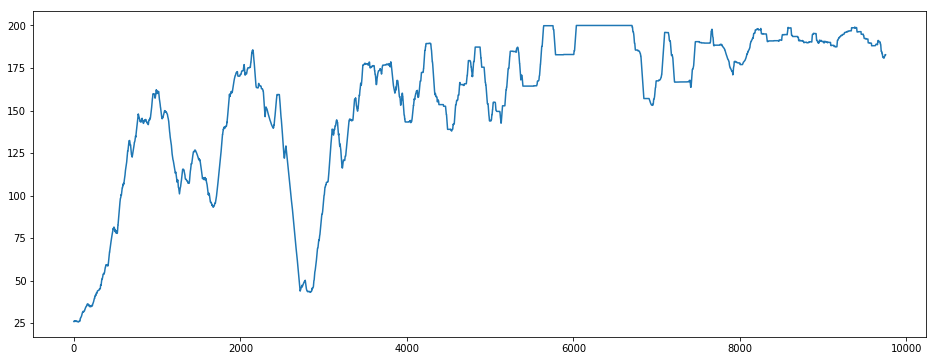

Game OVER


In [11]:
if __name__ == "__main__":
    random.seed(13)
    cartpole = CartPole(episodes=10000)
    scores = cartpole.run()
    scores = moving_average(scores, 250)
    plt.figure(figsize=(16,6))
    plt.plot(scores)
    plt.show()
    print("Game OVER")